In [1]:
import os
import sys
import numpy as np
from pathlib import Path
from keras import datasets
from typing import Optional
import matplotlib.pyplot as plt

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent.parent))

# Import the module from the custom library
from src.architectures.sequential import Sequential
from src.core.utils import data_analysis, data_processing, context_manager
from src import Tensor, layers, activations, loss_functions, optimizers, callbacks

### Constants and hyperparameters

In [3]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'cnn_autoencoder')

In [4]:

n_samples = 1000 # Number of samples to generate
train_test_split_pct = 0.2 # Percentage of samples to use for testing
learning_rate = 1e-03 # Learning rate for the optimizer
batch_size = 512 # Number of samples to use for each batch
gradient_accumulation_steps = 1 # Number of gradient accumulation steps
epochs = 30 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility
data_noise = 0.15 # Noise to add to the data

In [5]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [ ]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Add the channel dimension to the images
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Extract the number of classes in the dataset
num_classes = len(np.unique(train_labels))    

# Convert the lists to numpy arrays
X_train = Tensor(np.array(train_images))
y_train = Tensor(np.array(train_labels), dtype=np.int8)
X_test = Tensor(np.array(test_images))
y_test = Tensor(np.array(test_labels), dtype=np.int8)

# Split the training set into training, validation and testing sets
X_train, X_test, y_train, y_test = data_processing.split_data(data=(X_train, y_train), split_pct=train_test_split_pct, shuffle=True)[0]

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Testing set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (48000, 28, 28, 1) (48000,)
Testing set: (12000, 28, 28, 1) (12000,)


### Data processing

In [7]:
# Normalization
def normalize(X: Tensor) -> Tensor:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (Tensor): The input data to normalize
    
    Returns:
    - Tensor: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_test = normalize(X_test)

### Data visualization

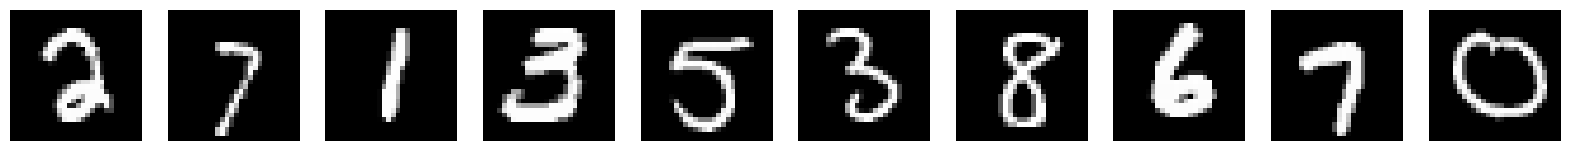

In [8]:
def plot_samples(samples: list[np.ndarray], labels: Optional[list[np.ndarray]] = None) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - samples (list[np.ndarray]): The samples to plot
    - labels (list[np.ndarray]): The labels of the samples
    """
        
    # Plot the samples in a grid
    _, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    
    # Ensure axes is always iterable
    if len(samples) == 1:
        axes = [axes]
        
    # Iterate through the samples
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
        if isinstance(labels, np.ndarray): 
            ax.set_title(f'Label: {labels[i]}')
        
# Plot the first 10 samples
plot_samples(list(X_train.data[:10]), list(y_train.data[:10]))

In [9]:
# Define the dimension of the latent space
latent_dim = 32

# Create the encoder
encoder = Sequential(
    name = 'Encoder',
    modules = [
        layers.Input(),
        layers.Conv2D(num_filters=16, kernel_size=(3, 3), activation=activations.ReLU(), padding='same'),
        layers.MaxPool2D(size=(2, 2), padding='same'),
        layers.Conv2D(num_filters=32, kernel_size=(3, 3), activation=activations.ReLU(), padding='same'),
        layers.MaxPool2D(size=(2, 2), padding='same'),
        layers.Flatten(),
        layers.Dense(num_units=latent_dim, activation=activations.ReLU(), name='Latent'),
    ]
)

# Create the decoder
decoder = Sequential(
    name = 'Decoder',
    modules = [
        layers.Input(name='Latent'),
        layers.Dense(num_units=7 * 7 * 32, activation=activations.ReLU()),
        layers.Reshape(shape=(7, 7, 32)),
        layers.Conv2D(num_filters=32, kernel_size=(3, 3), activation=activations.ReLU(), padding='same'),
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(num_filters=16, kernel_size=(3, 3), activation=activations.ReLU(), padding='same'),
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(num_filters=1, kernel_size=(3, 3), activation=activations.Sigmoid(), padding='same'),
    ]
)

# Create the auto-encoder
autoencoder = Sequential(
    name = 'Autoencoder',
    modules = [
        encoder,
        decoder
    ]
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate)

# Initialize the loss function
loss_fn = loss_functions.BinaryCrossEntropy()

### Initializing the model

In [ ]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    autoencoder.eval()
    
    # Call the model with a batch of data to initialize it
    autoencoder(x=X_train[:batch_size])

In [11]:
# Display the encoder summary
encoder.modules.summary()

# Display the decoder summary
decoder.modules.summary()

# Display the model summary
autoencoder.modules.summary()


encoder.modules

-----------------------------------------------------------------------------------------------
Module (type)                                          Output Shape        Trainable params #  
module_list.0 (Input)                                  (512, 28, 28, 1)    0                   
-----------------------------------------------------------------------------------------------
module_list.1 (Conv2D)                                 (512, 28, 28, 16)   160                 
-----------------------------------------------------------------------------------------------
module_list.2 (MaxPool2D)                              (512, 14, 14, 16)   0                   
-----------------------------------------------------------------------------------------------
module_list.3 (Conv2D)                                 (512, 14, 14, 32)   4640                
-----------------------------------------------------------------------------------------------
module_list.4 (MaxPool

### Training the model

In [ ]:
history = autoencoder.fit(
    train_data = {'x': X_train},
    valid_data = {'x': X_test},
    y_train = y_train,
    y_valid = y_test,
    optimizer = optimizer,
    loss_fn = loss_fn,
    batch_size = batch_size,
    epochs = epochs,
    gradient_accumulation_steps = gradient_accumulation_steps,
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/30 --> loss: 0.2809  | Validation loss: 0.1839                                                   
Epoch 2/30 --> loss: 0.1496  | Validation loss: 0.1293                                                   
Epoch 3/30 --> loss: 0.1218  | Validation loss: 0.1165                                                   
Epoch 4/30 --> loss: 0.1112  | Validation loss: 0.1093                                                   
Epoch 5/30 --> loss: 0.1058  | Validation loss: 0.1042                                                   
Epoch 6/30 --> loss: 0.1024  | Validation loss: 0.1007                                                   
Epoch 7/30 --> loss: 0.0998  | Validation loss: 0.0980                                                   
Epoch 8/30 --> loss: 0.0976  | Validation loss: 0.0969                                                   
Epoch 9/30 --> loss: 0.0960  | Validation loss: 0.0947                                                   
Epoch 10/30 --> loss: 0.0946  | Validation los

In [13]:
# Save the model
autoencoder.save(model_path)

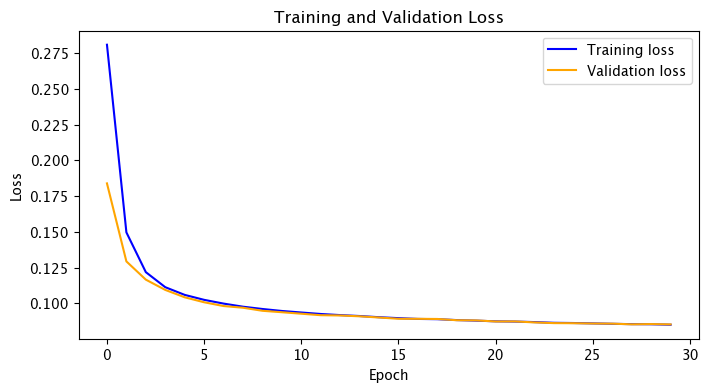

In [ ]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = history["loss"], 
    valid_loss = history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)

### Inference

In [15]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    encoder.eval()
    
    # Execute the encoder on the whole training set
    latent_train = encoder(
        x = X_train,
        batch_size = batch_size,
        verbose = True
    )

# Compute the mean and standard deviation of the latent space
latent_mean = np.mean(latent_train.data, axis=0)
latent_std = np.std(latent_train.data, axis=0)

Processing batch 94/94 - 433.07 ms/step

In [16]:
def sample_latent(num_samples: int = 1) -> np.ndarray:
    """
    Function to sample n random vectors from the latent space.
    
    Parameters:
    - num_samples (int): The number of samples to generate
    
    Returns:
    - np.ndarray: The samples generated from the latent space
    """
    
    # Sample the latent space
    return np.random.normal(latent_mean, latent_std, (num_samples, latent_dim))

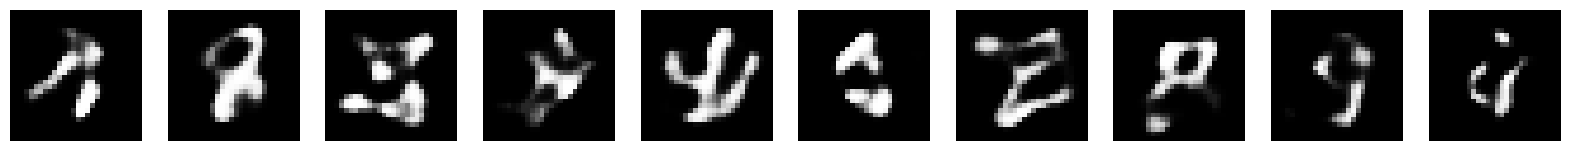

In [ ]:
# Sample one random vector from the latent space
samples = sample_latent(num_samples=10)

# Convert the samples to a tensor
samples = Tensor(samples)

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    decoder.eval()
    
    # Decode the sample to generate a new image
    decoded_imges = decoder(samples)

# Reshape the image to the original shape
decoded_imges = decoded_imges.reshape((-1, *X_train.shape[1:]))

# Plot the generated image
plot_samples(list(decoded_imges.data))